In [14]:
import sys, os
import numpy as np
import keras
import csv
import cv2

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU
from keras.layers.convolutional import Convolution2D

import matplotlib.pyplot as plt

from model import *

get_ipython().magic('matplotlib inline')
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['axes.titlesize'] = 8


get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


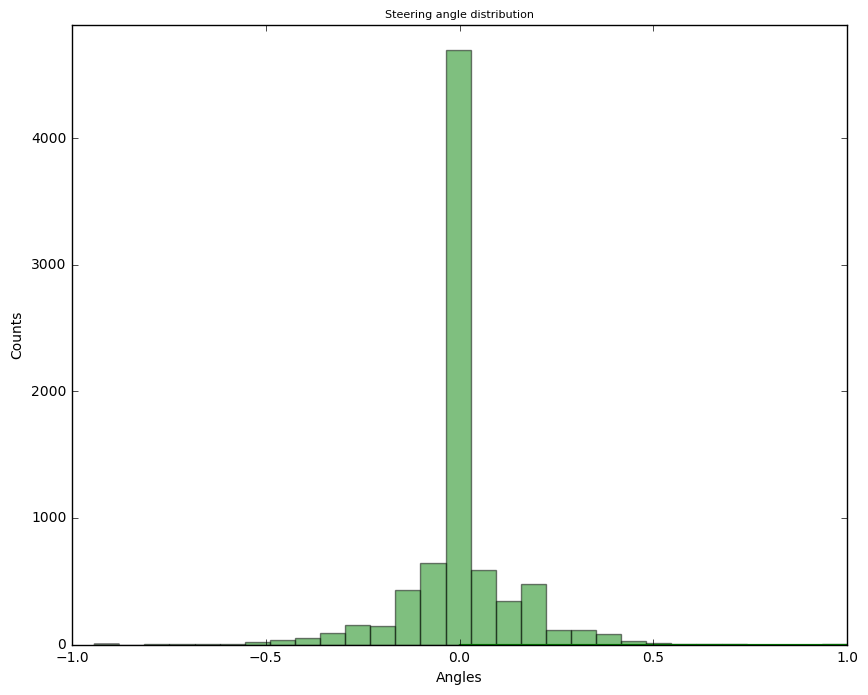

In [3]:
# Load the Udacity dataset. 
data_folder = "./data"
img_folder = "%s/IMG"%data_folder
steering_csv = "%s/driving_log.csv"%data_folder

steering = []
files = []

with open(steering_csv, 'r') as csvfile:
    rows = csv.reader(csvfile, delimiter=',')
    next(rows, None)
    for row in rows:
        steering.append(float(row[3]))
        files.append(["%s/%s"%(data_folder, row[i].strip()) for i in range(3)])

n, bins, _ = plt.hist(steering, 30, facecolor='green', alpha=0.5)
plt.plot(bins)
plt.title('Steering angle distribution')
plt.xlabel('Angles')
plt.ylabel('Counts')
plt.axis([-1, 1, 0, max(n)+200])

plt.show()

(160, 320, 3)
(80, 320, 3)
(64, 64, 3)


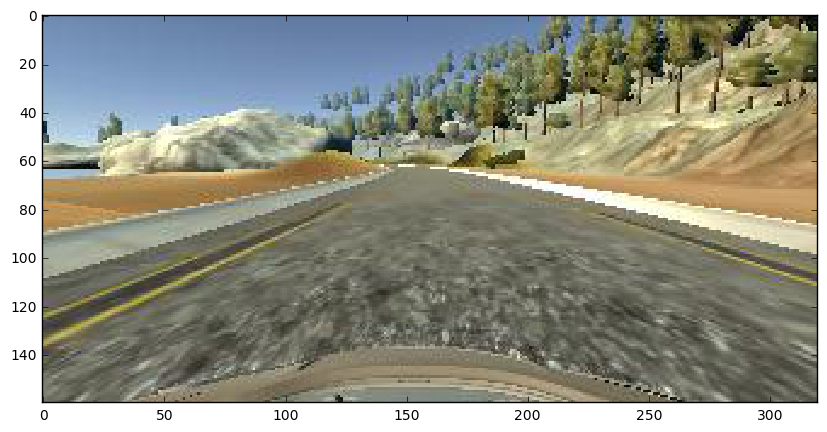

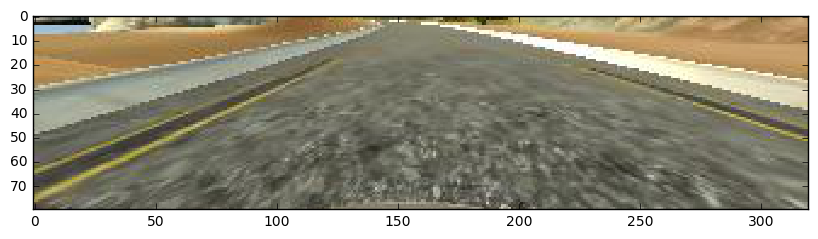

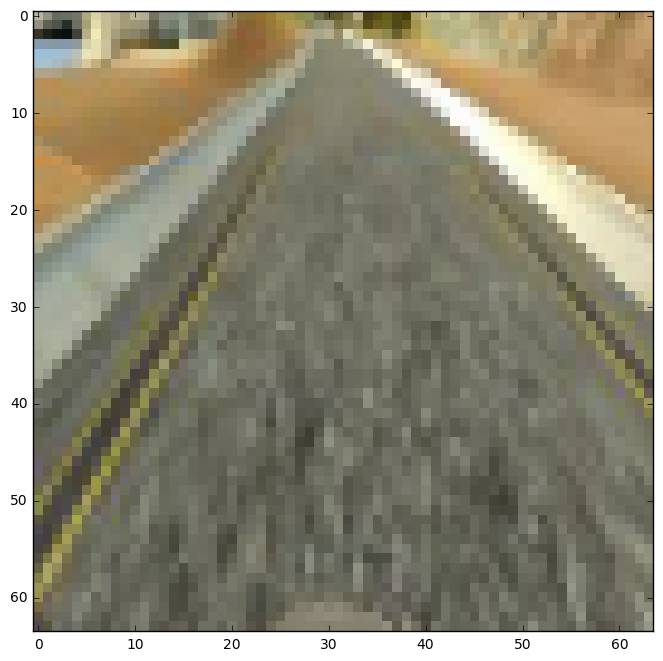

In [4]:
img = cv2.imread(files[np.random.randint(len(files))][0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
print (img.shape)

# ROI
roi = img[60:140, :, :]
plt.figure()
plt.imshow(roi)
print (roi.shape)

img = cv2.resize(roi, (64, 64), interpolation=cv2.INTER_AREA)
print (img.shape)
plt.figure()
plt.imshow(img)

plt.show()

In [5]:
def plot_random_sample(idxs, cols=3, camera=0):
    rows = int(np.ceil(len(idxs)/float(cols)))
    for i, idx in enumerate(idxs):
        img = cv2.imread(files[idx][camera])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(rows, cols,  i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title("%.2f"%(steering[idx]))

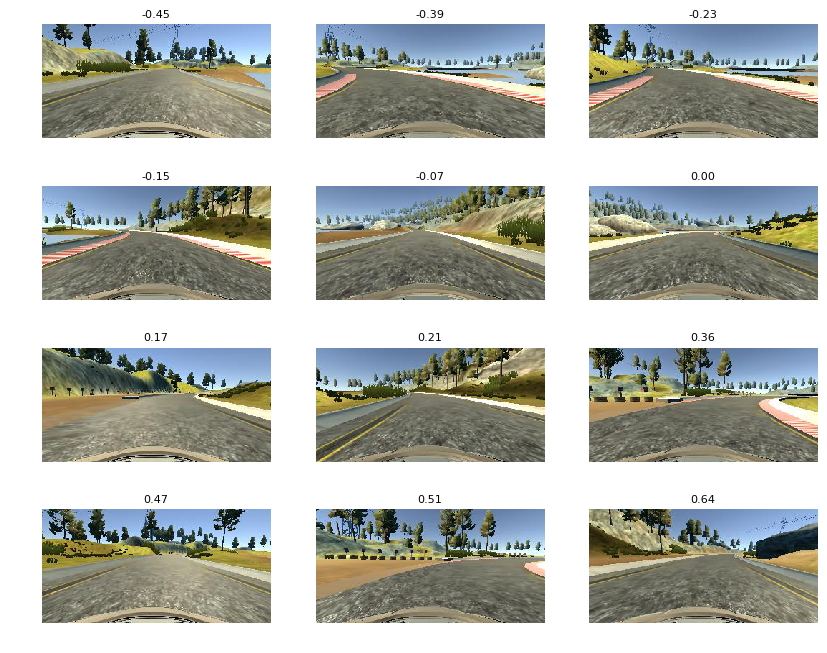

In [6]:
steering = np.array(steering)

angle = -0.5

subsample = []
for i in range(12):
    values = np.where(np.logical_and(steering >=angle, steering<(angle+0.1)))
    idxs = np.random.choice(values[0], 1)
    subsample.extend(idxs)
    angle = angle+0.1

plot_random_sample(subsample)

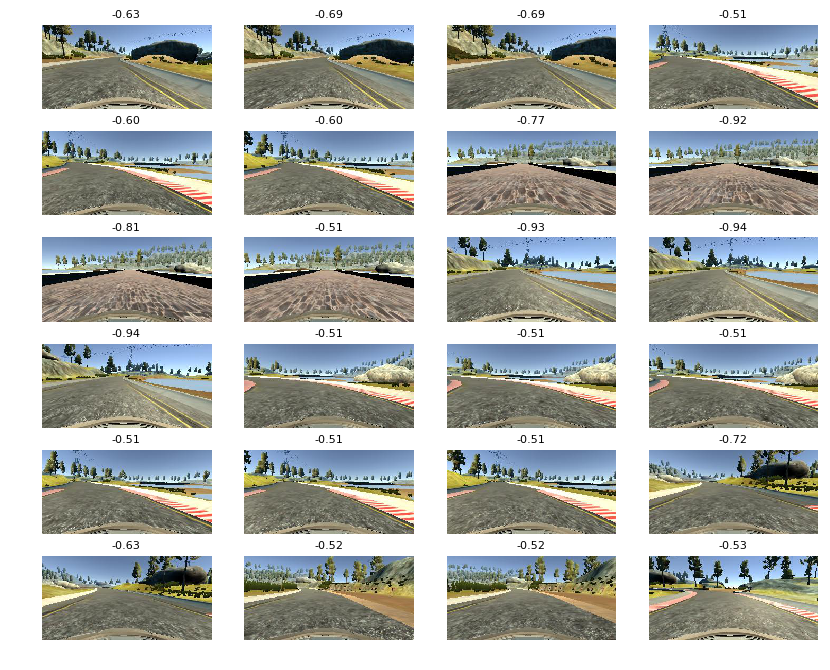

In [7]:
# Exploring values within a certain range. 
idx = np.flatnonzero(steering < -0.5)
plot_random_sample(idx, 4)

1.0
0.5
0.25


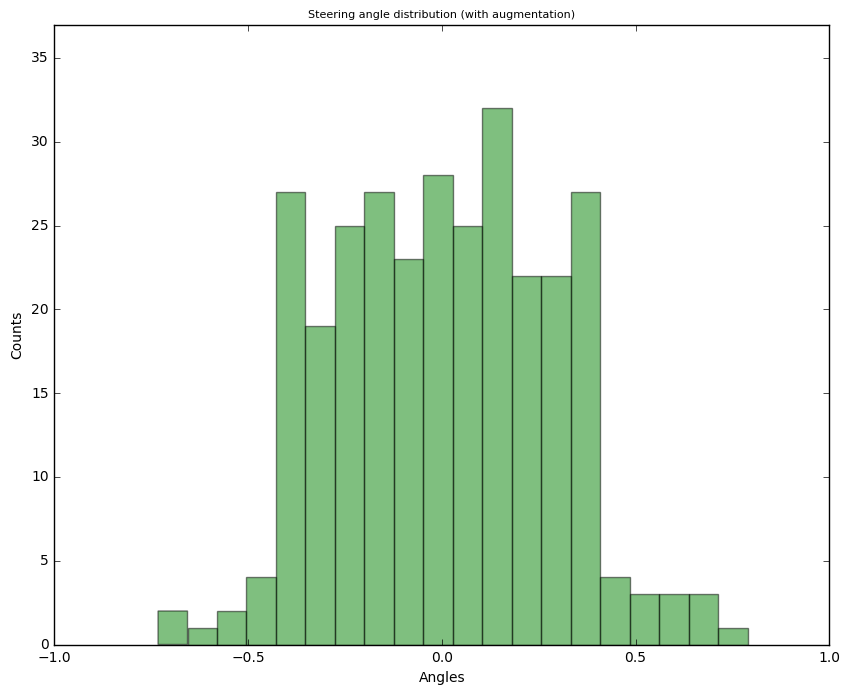

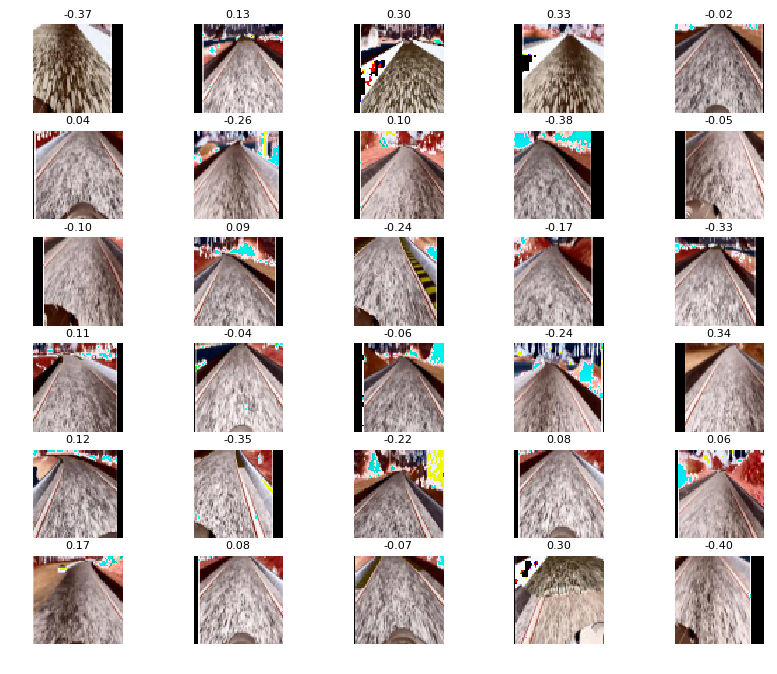

In [25]:
from model import *

reset_bias() # Start the bias at 1.0

train_X, train_y = next(training_generator(files, steering, 300))
train_X, train_y = next(training_generator(files, steering, 300))
train_X, train_y = next(training_generator(files, steering, 300))

n, bins, _ = plt.hist(train_y, 20, facecolor='green', alpha=0.5)
plt.plot(bins)
plt.title('Steering angle distribution (with augmentation)')
plt.xlabel('Angles')
plt.ylabel('Counts')
plt.axis([-1, 1, 0, max(n)+5])

plt.show()

plt.figure()
idxs = np.random.choice(train_X.shape[0], 30)
for i in range(len(idxs)):
    img = train_X[idxs[i]]
    plt.subplot(6, 5, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("%0.2f"%(train_y[idxs[i]]))
        

In [26]:
def getModel(key = "comma_ai"):
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,
                 input_shape = (row, col, ch)))
    
    if key == "comma_ai":
        model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
        model.add(ELU())
        model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
        model.add(ELU())
        model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
        model.add(Flatten())
        model.add(Dropout(.2))
        model.add(ELU())
        model.add(Dense(512))
        model.add(Dropout((.5)))
        model.add(ELU())
        model.add(Dense(1))
        
    return model


In [29]:
reset_bias()

row = 64
col = 64
ch = 3

model = getModel()
model.compile(optimizer="adam", loss="mse")

history = model.fit_generator(training_generator(files, steering), 
                    samples_per_epoch=12800, 
                    nb_epoch=30, 
                    verbose=2)

model.save("steering_model.h5")
print ("Model saved")

Epoch 1/30
1s - loss: 0.0063
Epoch 2/30
0s - loss: 9.6845e-04
Epoch 3/30
0s - loss: 7.2387e-04
Epoch 4/30
0s - loss: 5.7275e-04
Epoch 5/30
0s - loss: 4.8480e-04
Epoch 6/30
0s - loss: 4.2522e-04
Epoch 7/30
0s - loss: 3.7938e-04
Epoch 8/30
0s - loss: 3.7763e-04
Epoch 9/30
0s - loss: 3.4313e-04
Epoch 10/30
0s - loss: 3.2005e-04
Epoch 11/30
0s - loss: 3.1281e-04
Epoch 12/30
0s - loss: 2.9240e-04
Epoch 13/30
0s - loss: 2.9128e-04
Epoch 14/30
0s - loss: 3.0098e-04
Epoch 15/30
0s - loss: 2.7955e-04
Epoch 16/30
0s - loss: 2.7948e-04
Epoch 17/30
0s - loss: 2.7507e-04
Epoch 18/30
0s - loss: 2.6208e-04
Epoch 19/30
0s - loss: 2.3512e-04
Epoch 20/30
0s - loss: 2.6622e-04
Epoch 21/30
0s - loss: 2.5495e-04
Epoch 22/30
0s - loss: 2.5620e-04
Epoch 23/30
0s - loss: 2.4589e-04
Epoch 24/30
0s - loss: 2.3949e-04
Epoch 25/30
0s - loss: 2.5362e-04
Epoch 26/30
0s - loss: 2.4325e-04
Epoch 27/30
0s - loss: 2.3948e-04
Epoch 28/30
0s - loss: 2.3929e-04
Epoch 29/30
0s - loss: 2.6187e-04
Epoch 30/30
0s - loss: 2.53

In [ ]:
if 'acc' in history.history:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

if 'loss' in history.history:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()